# A/B Тестирование в Cookie Cats  
## Описание датасета  
Этот датасет содержит результаты A/B теста мобильной игры **Cookie Cats**.  
Цель теста - выяснить, как изменение уровня первого "замка" влияет на удержание игроков.  

### Данные в датасете:
В таблице 90189 игроков, которые были случайным образом распределены в две группы:
- **`Контрольная группа (gate_30)`** - игроки, у которых "замок" стоял на 30-м уровне.
- **`Тестовая группа (gate_40)`** - игроки, у которых "замок" стоял на 40-м уровне.

Структура датасета:
- **`userid`** - ID игрока  
- **`version`** - Группа (`gate_30` или `gate_40`)  
- **`sum_gamerounds`** - Количество сыгранных раундов  
- **`retention_1`** - Вернулся ли игрок через 1 день (True/False)  
- **`retention_7`** - Вернулся ли игрок через 7 дней (True/False)  

## Цель анализа:
Основная цель - определить, как изменение расположения первого "замка" (с уровня 30 на уровень 40) влияет на удержание игроков и их активность. Это поможет понять, какое из изменений способствует повышению вовлеченности пользователей.

## 1. Загрузка и преобразования данных

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import kagglehub

# Скачиваем датасет
path = kagglehub.dataset_download("mursideyarkin/mobile-games-ab-testing-cookie-cats")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\Олег\.cache\kagglehub\datasets\mursideyarkin\mobile-games-ab-testing-cookie-cats\versions\1


In [27]:
# Загружаем данные
df = pd.read_csv("../.cache/kagglehub/datasets/mursideyarkin/mobile-games-ab-testing-cookie-cats/versions/1/cookie_cats.csv")

In [28]:
# Посмотрим структуру данных
print(df.head())

   userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True


Проверим данные, на наличие дубликатов, нулевых значений, узнаем типы данных

In [42]:
# Проверяем на дубликаты
print("Количество дубликатов", df.duplicated().sum())
print()

# Проверка на пустые значения по столбцам
print("Количество пропусков по столбцам \n", df.isna().sum(), sep='')
print()

# Посмотрим на типы данных и общую информацию о датасете
print(df.info())

Количество дубликатов 0

Количество пропусков по столбцам 
userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB
None


Заметим, что в датасете не встречаются дубликаты, и пустые значения. Также данные имеют верные типы. 
Далее посмотрим на основные стат. характеристики.

In [45]:
df.groupby(by='version')[['sum_gamerounds']].describe()

sum_gamerounds                                                      
                 count       mean         std  min  25%   50%   75%      max
version                                                                     
gate_30        44700.0  52.456264  256.716423  0.0  5.0  17.0  50.0  49854.0
gate_40        45489.0  51.298776  103.294416  0.0  5.0  16.0  52.0   2640.0

Глядя на эти данные можно сделать следующие выводы, количество элементов групп примерно одинаково. В группе gate_30 наблюдается чуть большее значение
среднего, станадартное отклонение групп различается более чем в 2 раза. Также замечаем, что максимальное количество пройденных уровней в группе gate_30, 
намного превышает аналогичный показатели в gate_40. Изучим данный момент подробнее.

In [84]:
# Топ 5 пользователей по количество раундов в gate_30
print(df[df['version'] == 'gate_30'][['version','sum_gamerounds']].sort_values('sum_gamerounds',ascending=False).head(5).reset_index(drop=True))

# Топ 5 пользователей по количеству раундов в gate_40
print(df[df['version'] == 'gate_40'][['version','sum_gamerounds']].sort_values('sum_gamerounds',ascending=False).head(5).reset_index(drop=True))

   version  sum_gamerounds
0  gate_30           49854
1  gate_30            2961
2  gate_30            2438
3  gate_30            2251
4  gate_30            2156
   version  sum_gamerounds
0  gate_40            2640
1  gate_40            2294
2  gate_40            2124
3  gate_40            2063
4  gate_40            2015


Заметим, что значение 49854 в группе gate_30 слишком сильно отличается от всех остальных, избавимся от данного выброса. После заново посмотрим на основные стат. характеристики.

In [92]:
# Удаляем выброс
df = df.query("sum_gamerounds != 49854")

print(df.groupby(by='version')[['sum_gamerounds']].describe())

        sum_gamerounds                                                     
                 count       mean         std  min  25%   50%   75%     max
version                                                                    
gate_30        44699.0  51.342111  102.057598  0.0  5.0  17.0  50.0  2961.0
gate_40        45489.0  51.298776  103.294416  0.0  5.0  16.0  52.0  2640.0


В группе gate_30 и gate_40, после удаления выброса схожими значениями также стали среднее и стандарное отклонение,
максимальные же значения пройденных уровней теперь выглядят адекватно. Перейдем к дальнейшему анализу.

### 2. Визуализация данных

Визуализурем наши данные. Посмотрим на их распределения, и поймем какие стат. тесты будет правильно применять.

Для начала высчитаем Retention 1 и 7 дней

In [187]:
data = df.groupby('version')[['retention_1','retention_7','sum_gamerounds']].mean()
print(retention)

         retention_1  retention_7  sum_gamerounds
version                                          
gate_30     0.448198     0.190183       51.342111
gate_40     0.442283     0.182000       51.298776


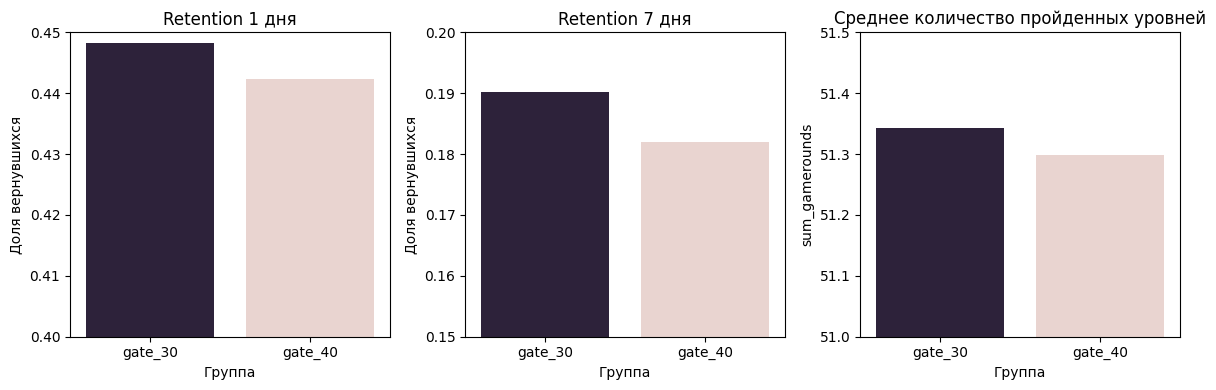

In [205]:
# Barplot для Retention 1ого и 7ого дня
plt.figure(figsize=(12, 4))

# Retention 1 дня
plt.subplot(1, 3, 1)
sns.barplot(data=data, x=data.index, y='retention_1', hue='retention_1')
plt.ylim(0.4,0.45)
plt.title('Retention 1 дня')
plt.xlabel('Группа')
plt.ylabel('Доля вернувшихся')
plt.legend([], [], frameon=False)

# Retention 7 дня
plt.subplot(1, 3, 2)
sns.barplot(data=data, x=data.index, y='retention_7', hue='retention_7')
plt.ylim(0.15,0.2)
plt.title('Retention 7 дня')
plt.xlabel('Группа')
plt.ylabel('Доля вернувшихся')
plt.legend([], [], frameon=False)

##############################################################################
# Barplot для sum_gamerounds
plt.subplot(1, 3, 3)
sns.barplot(data=data, x=data.index, y='sum_gamerounds', hue='sum_gamerounds')
plt.ylim(51, 51.5)
plt.title('Среднее количество пройденных уровней')
plt.xlabel('Группа')
plt.ylabel('sum_gamerounds')
plt.legend([], [], frameon=False)
plt.tight_layout()
plt.show()

Заметим, что в группе gate_30, более высокий Retention как 1ого дня так и 7ого, а также среднее значение пройденных уровней. Но является ли эти различия статистически значимымм определим в следующем разделе. Также посмотрим на распредление пройденных уровней.

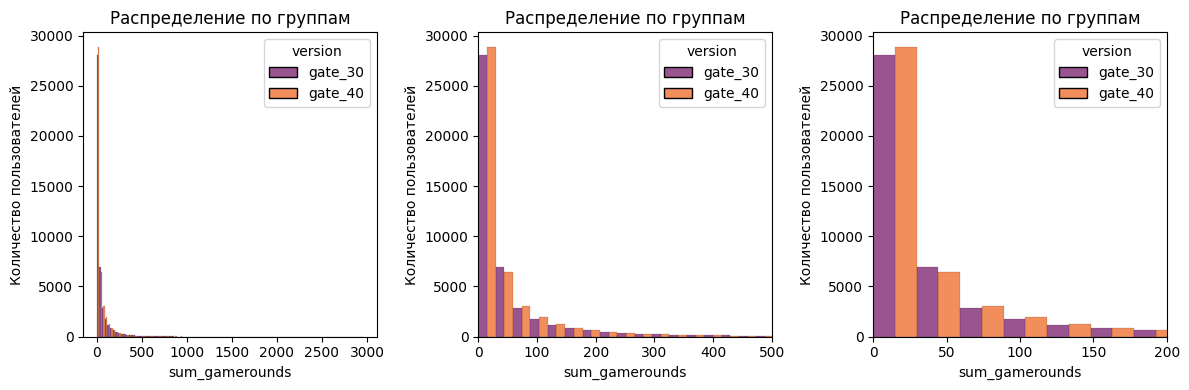

In [232]:
# Гистограмма для sum_gamerounds
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
sns.histplot(data=df, x='sum_gamerounds', hue='version', bins=100, palette='inferno', multiple='dodge')
plt.title('Распределение по группам')
plt.xlabel('sum_gamerounds')
plt.ylabel('Количество пользователей')

plt.subplot(1,3,2)
sns.histplot(data=df, x='sum_gamerounds', hue='version', bins=100, palette='inferno', multiple='dodge')
plt.xlim(0,500)
plt.title('Распределение по группам')
plt.xlabel('sum_gamerounds')
plt.ylabel('Количество пользователей')

plt.subplot(1,3,3)
sns.histplot(data=df, x='sum_gamerounds', hue='version', bins=100, palette='inferno', multiple='dodge')
plt.xlim(0,200)
plt.title('Распределение по группам')
plt.xlabel('sum_gamerounds')
plt.ylabel('Количество пользователей')
plt.tight_layout()
plt.show()

Замечаем, что распределение количества пройденных уровней является экспоненциальным.

### 3. Проведение стастических тестов

#### 3.1 Для анализа Retention, т.е. сравнения долей воспользуемся стат. тестом Хи-квадрат

**`Для Retention 1 дня:`**  <br>
**`H0:`**  Доля игроков, вернувшихся через 1 день, в группе gate_30 равна доле игроков, вернувшихся через 1 день, в группе gate_40. <br>
**`H1:`**  Доля игроков, вернувшихся через 1 день, в группе gate_30 отличается от доли игроков, вернувшихся через 1 день, в группе gate_40.

**`Для Retention 7 дня:`**  <br>
**`H0:`**  Доля игроков, вернувшихся через 7 дней, в группе gate_30 равна доле игроков, вернувшихся через 7 дней, в группе gate_40. <br>
**`H1:`**  Доля игроков, вернувшихся через 7 дней, в группе gate_30 отличается от доли игроков, вернувшихся через 7 дней, в группе gate_40.

In [267]:
from scipy import stats
# посчитаем сколько пользователей заходил в соотвествующие дни
retention_1_gate_30 = df[(df['version']=='gate_30') & (df['retention_1'] == True)]['retention_1'].count() # зашло на 1ый день в группе gate_30
retention_7_gate_30 = df[(df['version']=='gate_30') & (df['retention_7'] == True)]['retention_7'].count() # зашло на 7ой день в группе gate_30
n_gate_30 = df[df['version']=='gate_30']['retention_1'].count()                                           # зашло на 0ой день в группе gate_30

retention_1_gate_40 = df[(df['version']=='gate_40') & (df['retention_1'] == True)]['retention_1'].count() # зашло на 1ый день в группе gate_40
retention_7_gate_40 = df[(df['version']=='gate_40') & (df['retention_7'] == True)]['retention_7'].count() # зашло на 7ый день в группе gate_40
n_gate_40 = df[df['version']=='gate_40']['retention_1'].count()                                           # зашдл на 0ой день в группе gate_40

# Создаем таблицу сопряженности для Retention 1 дня
table_retention_1 = [
    [retention_1_gate_30, n_gate_30 - retention_1_gate_30],  # gate_30: вернулись/не вернулись
    [retention_1_gate_40, n_gate_40 - retention_1_gate_40]   # gate_40: вернулись/не вернулись
]

# Создаем таблицу сопряженности для Retention 7 дня
table_retention_7 = [
    [retention_7_gate_30, n_gate_30 - retention_7_gate_30],  # gate_30: вернулись/не вернулись
    [retention_7_gate_40, n_gate_40 - retention_7_gate_40]   # gate_40: вернулись/не вернулись
]

# Хи-квадрат тест
chi2_stat, p_value, dof, expected = stats.chi2_contingency(table_retention_1)
print(f"Хи-квадрат тест для Retention 1 дня: chi2-statistic={chi2_stat}, p-value={p_value}")

# Хи-квадрат тест
chi2_stat, p_value, dof, expected = stats.chi2_contingency(table_retention_7)
print(f"Хи-квадрат тест для Retention 7 дня: chi2-statistic={chi2_stat}, p-value={p_value}")

Хи-квадрат тест для Retention 1 дня: chi2-statistic=3.169835543170799, p-value=0.07500999897705692
Хи-квадрат тест для Retention 7 дня: chi2-statistic=9.915275528905669, p-value=0.0016391259678654423


**`Вывод:`** <br>
**`Retention 1 дня:`** <br>
Различия между группами gate_30 и gate_40 не являются статистически значимыми (p-value = 0.075 > 0.05).
**`Это означает, что изменение уровня первого "замка" с 30 на 40 не оказывает значимого влияния на удержание игроков через 1 день.`**

**`Retention 7 дня:`** <br>
Различия между группами gate_30 и gate_40 являются статистически значимыми (p-value = 0.0016 < 0.05).
**`Это означает, что изменение уровня первого "замка" с 30 на 40 оказывает значимое влияние на удержание игроков через 7 дней. Группа gate_30 показывает более высокие значения Retention 7 дней по сравнению с группой gate_40.`**

#### 3.2 Для анализа средних значений пройденных уровней воспользуемя бутстреппингом.

**`Для sum_gamerounds`**  <br>
**`H0:`**  Среднее количество пройденных уровней в группе gate_30 и группе gate_40 не различается. <br>
**`H1:`**  Среднее количество пройденных уровней в группе gate_30 и группе gate_40 различается.

Для сравнения средних значений пройденных уровней воспользуемя бутстреппингом. В данном случае он хорошо себя покажет, т.к. для него не
важно распределение исходных данных. Построим при помощи него доверительные интревалы, и посмотрим содержат ли они нуль.

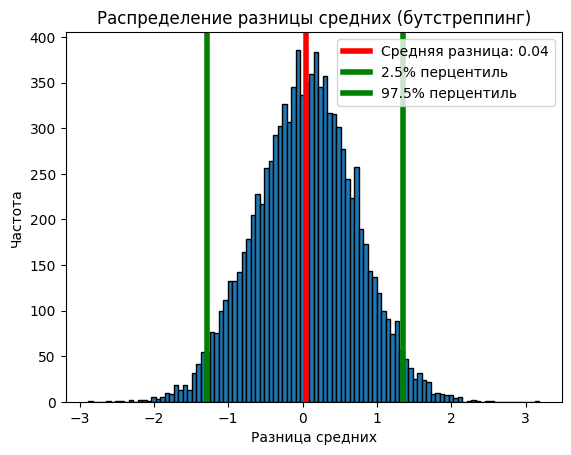

95% доверительный интервал для разницы средних: [-1.28497514  1.35164702]
Разница средних не является статистически значимой (0 внутри доверительного интервала).


In [290]:
# Функция для бутстреппинга разницы средних
def bootstrap_diff_means(data1, data2, n_iterations=10000):
    diffs = []
    for i in range(n_iterations):
        # Случайная выборка с заменой из данных
        sample1 = np.random.choice(data1, len(data1), replace=True)
        sample2 = np.random.choice(data2, len(data2), replace=True)
        # Разница средних в текущей итерации
        diffs.append(np.mean(sample1) - np.mean(sample2))
    return diffs

# Сформируем группки
group_30 = df[df['version']=='gate_30']['sum_gamerounds']
group_40 = df[df['version']=='gate_40']['sum_gamerounds']

# Бутстреппинг
diffs = bootstrap_diff_means(group_30, group_40)

# Визуализация
plt.hist(diffs, bins=100, edgecolor='black')
plt.axvline(x=np.mean(diffs), color='red', lw = 4, label=f'Средняя разница: {np.mean(diffs):.2f}')
plt.axvline(x=np.percentile(diffs, 2.5), color='green', lw = 4, label='2.5% перцентиль')
plt.axvline(x=np.percentile(diffs, 97.5), color='green', lw = 4, label='97.5% перцентиль')
plt.xlabel('Разница средних')
plt.ylabel('Частота')
plt.title('Распределение разницы средних (бутстреппинг)')
plt.legend()
plt.show()

# Вычисляем 95% доверительный интервал
confidence_interval = np.percentile(diffs, [2.5, 97.5])
print("95% доверительный интервал для разницы средних:", confidence_interval)

# Проверяем, включает ли доверительный интервал 0
if confidence_interval[0] < 0 < confidence_interval[1]:
    print("Разница средних не является статистически значимой (0 внутри доверительного интервала).")
else:
    print("Разница средних статистически значима (0 за пределами доверительного интервала).")

**`Вывод:`** <br>
**`sum_gamerounds:`** <br>
Различия между средними групп gate_30 и gate_40 не являются статистически значимыми.
**`Это означает, что изменение уровня первого "замка" с 30 на 40 не оказывает значимого влияния на среднее количество пройденных уровней.`**


### 4. Выводы

Ключевые результаты:
1) Retention 1 дня в группах gate_30 и gate_40 не различаются статистически значимо (p-value > 0.05). <br>
2) Retention 7 дня в группах gate_30 и gate_40 различаются статистически значимо (p-value < 0.05). <br>
3) Различия между средними значениями сыгранных раундов не являются статистически значемыми. <br>
4) Статистические тесты не подтвердили значимого эффекта от переноса замка на 40-й уровень.

Выводы:
1) Изменение не улучшает удержание игроков.
2) Дополнительные барьеры на 40-м уровне не дают бизнес-выгоды.
3) Нет оснований вводить это изменение в игру — оно не приводит к росту метрик вовлеченности.

Рекомендации:
1) Оставить замок на 30-м уровне, так как перенос не приносит пользы.
2) Рассмотреть другие способы увеличения метрик